# Technical notebook - Ecstasy usage prediction

**What is Ecstasy?**
https://adf.org.au/drug-facts/mdma/

Ecstasy is the common name of MDMA. However, some pills sold as ecstasy may only have a small amount of MDMA or none at all. Other drugs and ‘fillers’ are often used instead. This makes it hard to know what reactions to expect after taking MDMA or if negative side effects will be experienced.

Methylenedioxymethamphetamine (MDMA) is an an empathogen, which means it increases an individual’s feeling of empathy and compassion towards others.

**Other names**
Ecstasy, Eckies, E, XTC, pills, pingers, bikkies, flippers, molly.1

**How is MDMA used?**
MDMA usually comes in a tablet form and is swallowed. The pills come in different colours and sizes and are often imprinted with a picture or symbol.1 It can also come as capsules, powder or crystal.

**Effects of MDMA**

- euphoria
- feeling energetic and confident
- large pupils
- jaw clenching and teeth grinding
- heightened senses (sight, hearing and touch)
- excessive sweating and skin tingles
- muscle aches and pains
- reduced appetite
- fast heartbeat
- increased blood pressure
- dehydration
- heat stroke
- drinking extreme amounts of water (can cause death)

**Long term effects**

- colds or flu
- depression
- needing to use more to get the same effect
- dependence on MDMA
- memory and concentration problems
- financial, work and social problems

**Withdrawal**
Giving up MDMA after using it for a long time is challenging because the body has to get used to functioning without it. Withdrawal symptoms should settle down after a week and will mostly disappear after a month. 

## Research question: is it possible to predict from demographic and personality features that somebody becomes an ecstasy user?

### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import pickle

import warnings
warnings.filterwarnings("ignore")

# libraries for cleaning and preprocessing data
from sklearn.preprocessing import StandardScaler

# libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# libraries for evaluating models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from visualizations import *
from modeling import *

%load_ext autoreload
%autoreload 2

## 1. Preprocessing

### Upload the datafile

In [5]:
data = pd.read_csv('data/ecstasy.csv')

### Feature and target variables

In [6]:
y = data.User
X = data.drop(['User'], axis=1)

In [7]:
X.columns

Index(['Age', 'Gender', 'Education', 'Neuroticism', 'Extraversion',
       'Openness to experience', 'Agreeableness', 'Conscientiousness',
       'Impusivity', 'Sensation-seeking'],
      dtype='object')

### Train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=220, stratify=y)

In [9]:
y_train.mean()

0.39854111405835546

### Scaling

In [10]:
scaler = StandardScaler()
X_train_scaled = X_train
scaler.fit(X_train_scaled[['Age', 'Education']])
X_train_scaled[['Age', 'Education']] = scaler.transform(X_train_scaled[['Age', 'Education']])

In [11]:
X_train_scaled.head(2)

,Age,Gender,Education,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,Impusivity,Sensation-seeking
116,0.499858,1,0.009691,0.62967,-0.57545,0.14143,-1.77200,-0.40581,0.52975,-0.21575
965,-1.051141,0,-0.552366,-0.24649,0.16767,1.88511,1.45039,-0.40581,1.29221,1.22470


In [12]:
X_test_scaled = X_test
X_test_scaled[['Age', 'Education']] = scaler.transform(X_test_scaled[['Age', 'Education']])

In [13]:
scaler.mean_

array([1.35543767, 4.98275862])

In [14]:
scaler.var_

array([1.66278873, 3.16548523])

## 2. Modeling

We were comparing the following models:
    - Logistic regression
    - Decesion tree
    - Random forest
    - Gradient boosting
    - XGBoosting
    - K Nearest Neighbors
    - Support Vector Machine

To select the best performing parameters we were applying gridsearch.

Every model is tested on the test set. Big difference between 'Best score' and 'Test score' implies overfitting of the model.


## 2.1. Logistic regression

In [18]:
params = {'C': np.logspace(-2, 4, 7),
          'penalty' : ['l1','l2']}

log_grid = run_gridsearch_scaled(LogisticRegression, params,
                               X_train_scaled, X_test_scaled,
                               y_train, y_test, random_state=123)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.01, 'penalty': 'l2'}
Train score: 0.749
Test score: 0.732


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished


In [18]:
coefs = pd.DataFrame(zip(X.columns, log_grid.best_estimator_.coef_[0]), columns=['Feature', 'Coef'])
coefs.sort_values(by='Coef')

,Feature,Coef
0,Age,-0.505322
7,Conscientiousness,-0.182681
2,Education,-0.168978
6,Agreeableness,-0.082988
3,Neuroticism,0.034934
4,Extraversion,0.047621
8,Impulsiveness,0.075002
1,Gender,0.106554
5,Openness,0.333606
9,Sensation-seeking,0.388443


## 2.2. Decision tree

In [22]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [3, 4, 5, 6, 7],
          'min_samples_split': [20, 40, 60, 80],
          'min_impurity_split': [0.03, 0.05, 0.1, 0.2]}

tree_grid = run_gridsearch(DecisionTreeClassifier, params,
                           X_train, X_test,
                           y_train, y_test, random_state=111)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'criterion': 'gini', 'max_depth': 4, 'min_impurity_split': 0.2, 'min_samples_split': 40}
Train score: 0.735
Test score: 0.727


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.1s finished


In [21]:
feat_imp = pd.DataFrame(zip(X.columns, tree_grid.best_estimator_.feature_importances_), 
                        columns=['Feature', 'Importance'])
feat_imp

,Feature,Importance
0,Age,0.302462
1,Gender,0.032392
2,Education,0.018051
3,Neuroticism,0.011372
4,Extraversion,0.000000
5,Openness,0.082476
6,Agreeableness,0.011631
7,Conscientiousness,0.062216
8,Impulsiveness,0.000000
9,Sensation-seeking,0.479400


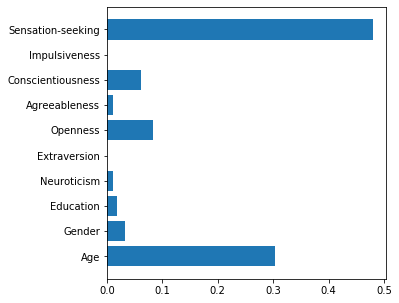

In [22]:
plt.figure(figsize=(5,5))
plt.barh(feat_imp.Feature, feat_imp.Importance);

## 2.3. Random Forest

In [24]:
params = {'n_estimators': [10, 100, 200, 500],
          'criterion': ['gini', 'entropy'],
          'max_depth': [2, 4, 6, 8, 10],
          'max_features': [2, 4, 6, 8]}

rf_grid = run_gridsearch(RandomForestClassifier, params,
                         X_train, X_test,
                         y_train, y_test, random_state=222)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   55.2s


Best params: {'criterion': 'gini', 'max_depth': 4, 'max_features': 4, 'n_estimators': 10}
Train score: 0.746
Test score: 0.721


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   57.8s finished


In [26]:
feat_imp_rf = pd.DataFrame(zip(X.columns, rf_grid.best_estimator_.feature_importances_), 
                        columns=['Feature', 'Importance'])
feat_imp_rf.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp_rf

,Feature,Importance
0,Age,0.206653
9,Sensation-seeking,0.187875
5,Openness,0.148012
7,Conscientiousness,0.095973
2,Education,0.073912
8,Impulsiveness,0.064825
4,Extraversion,0.060068
3,Neuroticism,0.059851
6,Agreeableness,0.055942
1,Gender,0.046888


## 2.4. Gradient Boosting

In [25]:
params = {"learning_rate": [0.1, 0.2, 0.4],
          'max_depth': [2, 3, 4, 5],
          'max_features': [2, 3, 4, 5],
          'n_estimators': [10, 50, 100, 200],
          }

g_boost = run_gridsearch(GradientBoostingClassifier, params,
                         X_train, X_test,
                         y_train, y_test, random_state=123)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 867 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 945 out of 960 | elapsed:   18.0s remaining:    0.3s


Best params: {'learning_rate': 0.4, 'max_depth': 5, 'max_features': 3, 'n_estimators': 10}
Train score: 0.749
Test score: 0.714


[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   18.7s finished


In [31]:
feat_imp_gb = pd.DataFrame(zip(X.columns, g_boost.best_estimator_.feature_importances_), 
                        columns=['Feature', 'Importance'])
feat_imp_gb.sort_values(by='Importance', ascending=False)

,Feature,Importance
9,Sensation-seeking,0.243655
0,Age,0.208606
5,Openness,0.155950
2,Education,0.090225
7,Conscientiousness,0.074847
3,Neuroticism,0.058696
4,Extraversion,0.046805
6,Agreeableness,0.044582
8,Impulsiveness,0.039006
1,Gender,0.037627


## 2.5. XGBoost

In [26]:
params = {"learning_rate": [0.1, 0.2],
          'max_depth': [2, 3, 4, 5],
          'min_child_weight': [0.1, 0.2, 0.3],
          'subsample': [0.2, 0.3, 0.5],
          'n_estimators': [50, 100, 150, 200],
          }

xg_boost = run_gridsearch(xgb.XGBClassifier, params,
                          X_train, X_test,
                          y_train, y_test, random_state=234)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 631 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 1381 tasks      | elapsed:   38.6s


Best params: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 0.1, 'n_estimators': 50, 'subsample': 0.3}
Train score: 0.747
Test score: 0.711


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   41.0s finished


## 2.6. KNN 

In [27]:
params = {'n_neighbors': range(1, 30, 2)}


knn_grid = run_gridsearch_scaled(KNeighborsClassifier, params,
                                 X_train_scaled, X_test_scaled,
                                 y_train, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'n_neighbors': 25}
Train score: 0.737
Test score: 0.703


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.4s finished


## 2.7. Support Vector Machine

In [33]:
params = {'kernel': ['linear', 'poly', 'rbf'],
          'C': [0.1, 1, 10, 1000], #high C allows narrow mistakes
          'degree': [2, 3]}


svm_grid = run_gridsearch_scaled('SVM', params,
                                 X_train_scaled, X_test_scaled,
                                 y_train, y_test, random_state=766)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.5s finished


Best params: {'C': 1, 'degree': 2, 'kernel': 'linear'}
Train score: 0.755
Test score: 0.727


## FINDINGS

## 3.1. ROC curves

We are using ROC (Receiver Operating Characteristic) curves and AUC (Area Under the Curve) to compare the performance of different models and select the most predictible one. The x axis of the ROC curve is the False Positive Rate (we want to minimize it), the y axis is the True Positive Rate (we want to maximize it). So, a model which follows the dotted black line is not better than a random guess, a model which lies is above it, and goes along the y axes (AUC = 1) are the perfect predictors. The area under the curve is the quantification of the ROC curves, and the higher is the number, the better predictor is the model. AUC = 1 is the perfect predictor.

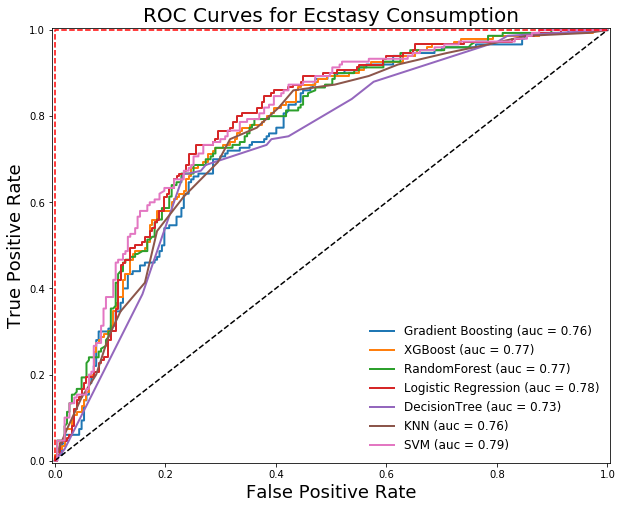

In [34]:
models = [g_boost, xg_boost, rf_grid, log_grid, tree_grid, knn_grid, svm_grid]

model_names = ['Gradient Boosting', 'XGBoost',
               'RandomForest', 'Logistic Regression',
               'DecisionTree', 'KNN', 'SVM']

plot_roc_curve(models, model_names, X_test, X_test_scaled, y_test, 'Ecstasy')

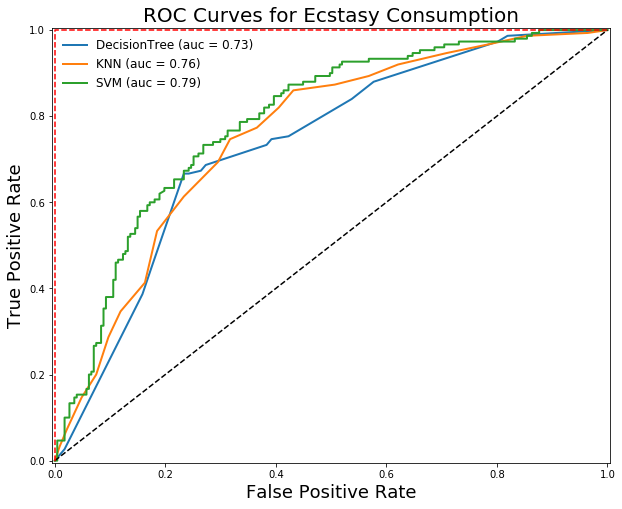

In [36]:
models = [tree_grid, knn_grid, svm_grid]

model_names = ['DecisionTree', 'KNN', 'SVM']

plot_roc_curve(models, model_names, X_test,
               X_test_scaled, y_test, 'Ecstasy')

According to the ROC and AUC result, we were choosing SVM model as the best predictor for predicting that somebody becomes ecstasy user.

## 3.2 Interprete the result of the SVM model

In [43]:
feat_imp_svm = pd.DataFrame(zip(X.columns, svm_grid.best_estimator_.coef_[0]), 
                        columns=['Feature', 'Coefficient'])
feat_imp_svm['Absolute Coefficient'] = feat_imp_svm.Coefficient.apply(lambda x: abs(x))
feat_imp_svm = feat_imp_svm.sort_values(by='Absolute Coefficient')

In [44]:
feat_imp_svm

,Feature,Coefficient,Absolute Coefficient
3,Neuroticism,0.013300,0.013300
8,Impusivity,-0.037726,0.037726
4,Extraversion,0.044689,0.044689
6,Agreeableness,-0.071096,0.071096
2,Education,-0.151085,0.151085
7,Conscientiousness,-0.200047,0.200047
5,Openness to experience,0.367234,0.367234
9,Sensation-seeking,0.445001,0.445001
1,Gender,0.452999,0.452999
0,Age,-0.629330,0.629330


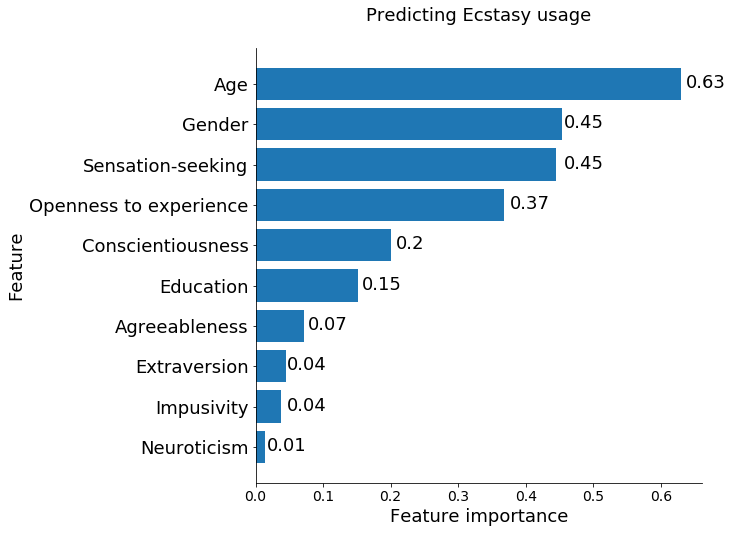

In [50]:
plot_feat_imp('SVM', feat_imp_svm, 'Ecstasy')
plt.savefig('img/feature_imp_ecstasy2.png', bbox_inches='tight')

In case of SVM model, if the kernel is linear, the feature importance is available from coefficients, since our variables are scaled. The absolute value of the coefficient can be interpreted as the featuer importance, the positive/negative value can be interpreted as their relation to becoming an ecstasy user. (For example: the higher is the openness, sensation score, it is more likely, however the older and more educated is less likely to become an ecsatsy user.)

## 3.3. Confusion Matrix

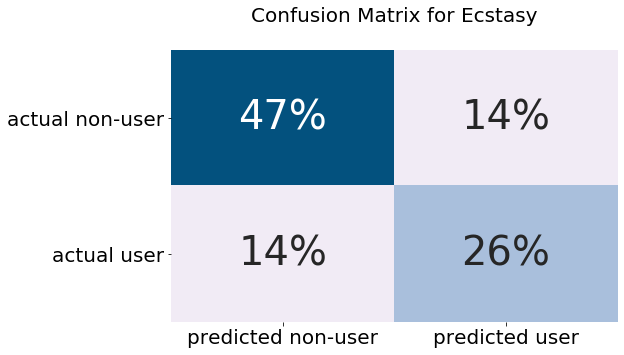

In [51]:
plot_confusion_matrix(y_test, X_test_scaled, svm_grid, 'Ecstasy')
plt.savefig('img/conf_m_ecstasy.png', bbox_inches='tight')